In [2]:
import pandas as pd
import sqlite3
import seaborn as sns

In [73]:
# connect to sqlite

conn = sqlite3.connect("../data/bootcamp_db")

In [74]:
query = """
select customer_id,
       country,
       count(distinct invoice) as number_orders,
       max(invoice_date) as last_invoice_date,
       sum(total_order_value) as total_spent,
       count(distinct stock_code) as number_distinct_items
from online_transactions_fixed
group by customer_id, country
"""

customer_data = pd.read_sql(query, conn)

In [75]:
customer_data.shape

(4371, 6)

In [76]:
customer_data.head()

,customer_id,country,number_orders,last_invoice_date,total_spent,number_distinct_items
0,u12346,United Kingdom,2,2011-01-18T10:17:00,0.00,1
1,u12347,Iceland,7,2011-12-07T15:52:00,4310.00,103
2,u12348,Finland,4,2011-09-25T13:13:00,1437.24,21
3,u12349,Italy,1,2011-11-21T09:51:00,1457.55,72
4,u1235,Norway,1,2011-02-02T16:01:00,294.40,16


In [77]:
# creating segments based on the country

def create_customer_segments(i):
    if i == "United Kingdom":
        return "UK customer"
    else:
        return "Non-UK customer"

In [78]:
customer_data['customer_segment']  = customer_data.country.apply(create_customer_segments)

In [79]:
customer_data.head()

,customer_id,country,number_orders,last_invoice_date,total_spent,number_distinct_items,customer_segment
0,u12346,United Kingdom,2,2011-01-18T10:17:00,0.00,1,UK customer
1,u12347,Iceland,7,2011-12-07T15:52:00,4310.00,103,Non-UK customer
2,u12348,Finland,4,2011-09-25T13:13:00,1437.24,21,Non-UK customer
3,u12349,Italy,1,2011-11-21T09:51:00,1457.55,72,Non-UK customer
4,u1235,Norway,1,2011-02-02T16:01:00,294.40,16,Non-UK customer


In [80]:
# look at distribution of customers

customer_data.customer_segment.value_counts()

customer_segment
UK customer        3943
Non-UK customer     428
Name: count, dtype: int64

In [81]:
# can view as % instead of whole numbers 
customer_data.customer_segment.value_counts(normalize=True)

customer_segment
UK customer        0.902082
Non-UK customer    0.097918
Name: proportion, dtype: float64

In [82]:
# look at the UK customer segment

uk_customers = customer_data[customer_data.customer_segment == "UK customer"]
uk_customers.head()

,customer_id,country,number_orders,last_invoice_date,total_spent,number_distinct_items,customer_segment
0,u12346,United Kingdom,2,2011-01-18T10:17:00,0.00,1,UK customer
335,u12747,United Kingdom,11,2011-12-07T14:34:00,4196.01,42,UK customer
336,u12748,United Kingdom,217,2011-12-09T12:20:00,29819.99,1767,UK customer
337,u12749,United Kingdom,8,2011-12-06T09:56:00,3868.20,160,UK customer
382,u1282,United Kingdom,4,2011-12-06T15:12:00,942.34,55,UK customer


In [83]:
uk_customers.describe()

,number_orders,total_spent,number_distinct_items
count,3943.000000,3943.000000,3943.000000
mean,4.966523,1728.474535,60.475273
std,8.479952,6664.878209,81.677559
min,1.000000,-1192.200000,1.000000
25%,1.000000,283.590000,15.000000
50%,3.000000,626.090000,35.000000
75%,5.000000,1520.295000,77.000000
max,217.000000,259657.300000,1767.000000


In [84]:
non_uk_customers.describe()

NameError: name 'non_uk_customers' is not defined

In [85]:
non_uk_customers = customer_data[customer_data.customer_segment == "Non-UK customer"]
non_uk_customers.head()

,customer_id,country,number_orders,last_invoice_date,total_spent,number_distinct_items,customer_segment
1,u12347,Iceland,7,2011-12-07T15:52:00,4310.00,103,Non-UK customer
2,u12348,Finland,4,2011-09-25T13:13:00,1437.24,21,Non-UK customer
3,u12349,Italy,1,2011-11-21T09:51:00,1457.55,72,Non-UK customer
4,u1235,Norway,1,2011-02-02T16:01:00,294.40,16,Non-UK customer
5,u12352,Norway,8,2011-11-03T14:37:00,1265.41,57,Non-UK customer


Findings:
- The Non UK customer segment makes up 10% of our customer base but.. 
- On average the non UK customser segments spends twice as much as UK customers (3.4k vs 1.7k), and 75% of non UK customers spend 2.3k vs 1.5k, even though there are no difference in average/median orders placed.
- Next steps would be to calculate the recency and explore the outliers...
- Suggestion to company - increase marketing spend for non UK customers

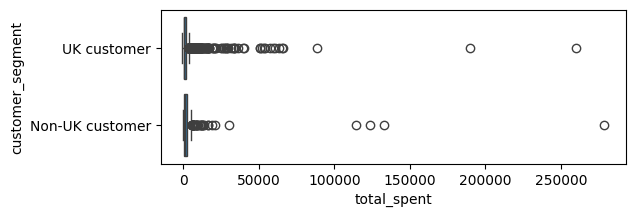

In [86]:
sns.boxplot(y="customer_segment", x="total_spent", data=customer_data);

In [ ]:
# for reference, code to normalize a variable


customer_data['total_spent_normalised'] = (customer_data.total_spent - customer_data.total_spent.min())/(customer_data.total_spent.max() - customer_data.total_spent.min())



In [49]:
# visualising the amount the top 20 customers spend per segment

query = """
        with customer_spend as (select customer_id,
                               case when Country = 'United Kingdom' then 'UK Customers' else 'Non UK Customer' end as customer_segment,
                               sum(total_order_value) as total_spend
                        from online_transactions_fixed
                        group by customer_id
                        order by total_spend desc)

        select *
        from
            (select customer_id,
                   customer_segment,
                   total_spend,
                   rank() over (partition by customer_segment order by total_spend desc) as rank
            from customer_spend)
        where rank < 20
"""

top_customers = pd.read_sql(query, conn)

In [51]:
top_customers

,customer_id,customer_segment,total_spend,rank
0,u14646,Non UK Customer,278778.02,1
1,u14911,Non UK Customer,132893.24,2
2,u12415,Non UK Customer,123638.18,3
3,u14156,Non UK Customer,114335.77,4
4,u17404,Non UK Customer,30175.82,5
5,u12753,Non UK Customer,21024.01,6
6,u12731,Non UK Customer,18660.41,7
7,u12678,Non UK Customer,16441.26,8
8,u12471,Non UK Customer,16323.52,9
9,u12433,Non UK Customer,13375.87,10


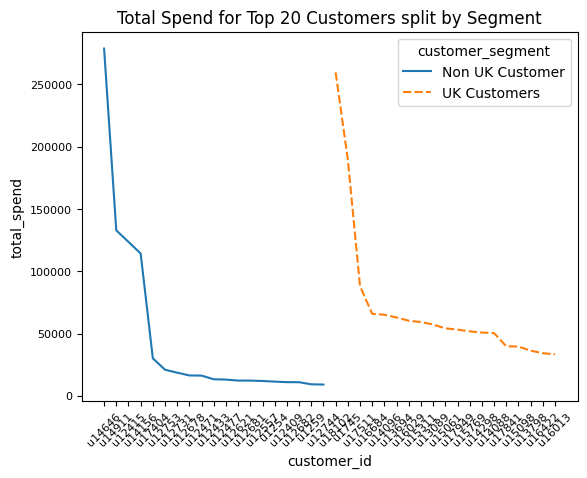

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x="customer_id", y="total_spend", hue="customer_segment", style="customer_segment", data=top_customers)
plt.title("Total Spend for Top 20 Customers split by Segment")
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8);

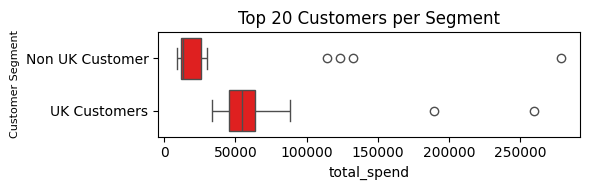

In [87]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 6, 2

sns.boxplot(x="total_spend", y="customer_segment", data=top_customers, color="red")
plt.ylabel("Customer Segment", fontsize=8)
plt.title("Top 20 Customers per Segment")
plt.tight_layout();